Necessary Imports

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import collections
from tensorflow import keras
print(tf.__version__)

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


2.9.2


In [2]:
import os
import tensorflow
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D

from keras.models import Model                     #transfer learning
from keras.optimizers import Adam

Importing the data and extracting it

In [3]:
def get_data():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    print("Downloading the data...")
    !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
    print("Dataset Downloaded")
    print("Extracting...")
    !tar xzvf food-101.tar.gz
    print("Extraction done!")



In [4]:
get_data()

Streaming output truncated to the last 5000 lines.
food-101/images/cannoli/1767088.jpg
food-101/images/cannoli/3201965.jpg
food-101/images/cannoli/3778102.jpg
food-101/images/cannoli/2674065.jpg
food-101/images/cannoli/1169899.jpg
food-101/images/cannoli/1378086.jpg
food-101/images/cannoli/803909.jpg
food-101/images/cannoli/1067240.jpg
food-101/images/cannoli/3002709.jpg
food-101/images/cannoli/2612632.jpg
food-101/images/cannoli/3627612.jpg
food-101/images/cannoli/1798703.jpg
food-101/images/cannoli/560632.jpg
food-101/images/cannoli/512468.jpg
food-101/images/cannoli/2331523.jpg
food-101/images/cannoli/3118302.jpg
food-101/images/cannoli/1499412.jpg
food-101/images/cannoli/1557459.jpg
food-101/images/cannoli/146566.jpg
food-101/images/cannoli/96922.jpg
food-101/images/cannoli/1699562.jpg
food-101/images/cannoli/730051.jpg
food-101/images/cannoli/2177977.jpg
food-101/images/cannoli/2767028.jpg
food-101/images/cannoli/6564.jpg
food-101/images/cannoli/553447.jpg
food-101/images/cannoli/

In [5]:
!ls food-101/           #checking extracted dataset folder

images	license_agreement.txt  meta  README.txt


In [6]:
os.listdir('food-101/images')           #values of different classes

['french_toast',
 'mussels',
 'grilled_salmon',
 'sashimi',
 'pho',
 'beef_tartare',
 'cheese_plate',
 'filet_mignon',
 'chocolate_mousse',
 'pizza',
 'beef_carpaccio',
 'shrimp_and_grits',
 'spaghetti_bolognese',
 'huevos_rancheros',
 'bruschetta',
 'caesar_salad',
 'greek_salad',
 'foie_gras',
 'tiramisu',
 'waffles',
 'donuts',
 'chicken_quesadilla',
 'escargots',
 'samosa',
 'apple_pie',
 'hamburger',
 'spring_rolls',
 'steak',
 'tuna_tartare',
 'macarons',
 'peking_duck',
 'bread_pudding',
 'croque_madame',
 'crab_cakes',
 'scallops',
 'tacos',
 'falafel',
 'edamame',
 'lasagna',
 'bibimbap',
 'caprese_salad',
 'paella',
 'gnocchi',
 'ice_cream',
 'lobster_bisque',
 'fried_calamari',
 'oysters',
 'sushi',
 'seaweed_salad',
 'gyoza',
 'eggs_benedict',
 'hot_and_sour_soup',
 'beignets',
 'guacamole',
 'fried_rice',
 'strawberry_shortcake',
 'chicken_wings',
 'nachos',
 'ramen',
 'red_velvet_cake',
 'onion_rings',
 'hummus',
 'grilled_cheese_sandwich',
 'beet_salad',
 'clam_chowder',

We have four files, meta -> contains text files - train.txt and test.txt
train.txt -> list of images belonging to training set
test.txt -> list of images belonging to testing set
class.txt -> list of all classes of food

In [7]:
os.listdir('food-101/meta')

['train.txt',
 'train.json',
 'labels.txt',
 'classes.txt',
 'test.txt',
 'test.json']

In [8]:
!head food-101/meta/train.txt     #example of train.txt

apple_pie/1005649
apple_pie/1014775
apple_pie/1026328
apple_pie/1028787
apple_pie/1043283
apple_pie/1050519
apple_pie/1057749
apple_pie/1057810
apple_pie/1072416
apple_pie/1074856


In [9]:
!head food-101/meta/classes.txt     #example of classes.txt

apple_pie
baby_back_ribs
baklava
beef_carpaccio
beef_tartare
beet_salad
beignets
bibimbap
bread_pudding
breakfast_burrito


Let us plot each type of data category

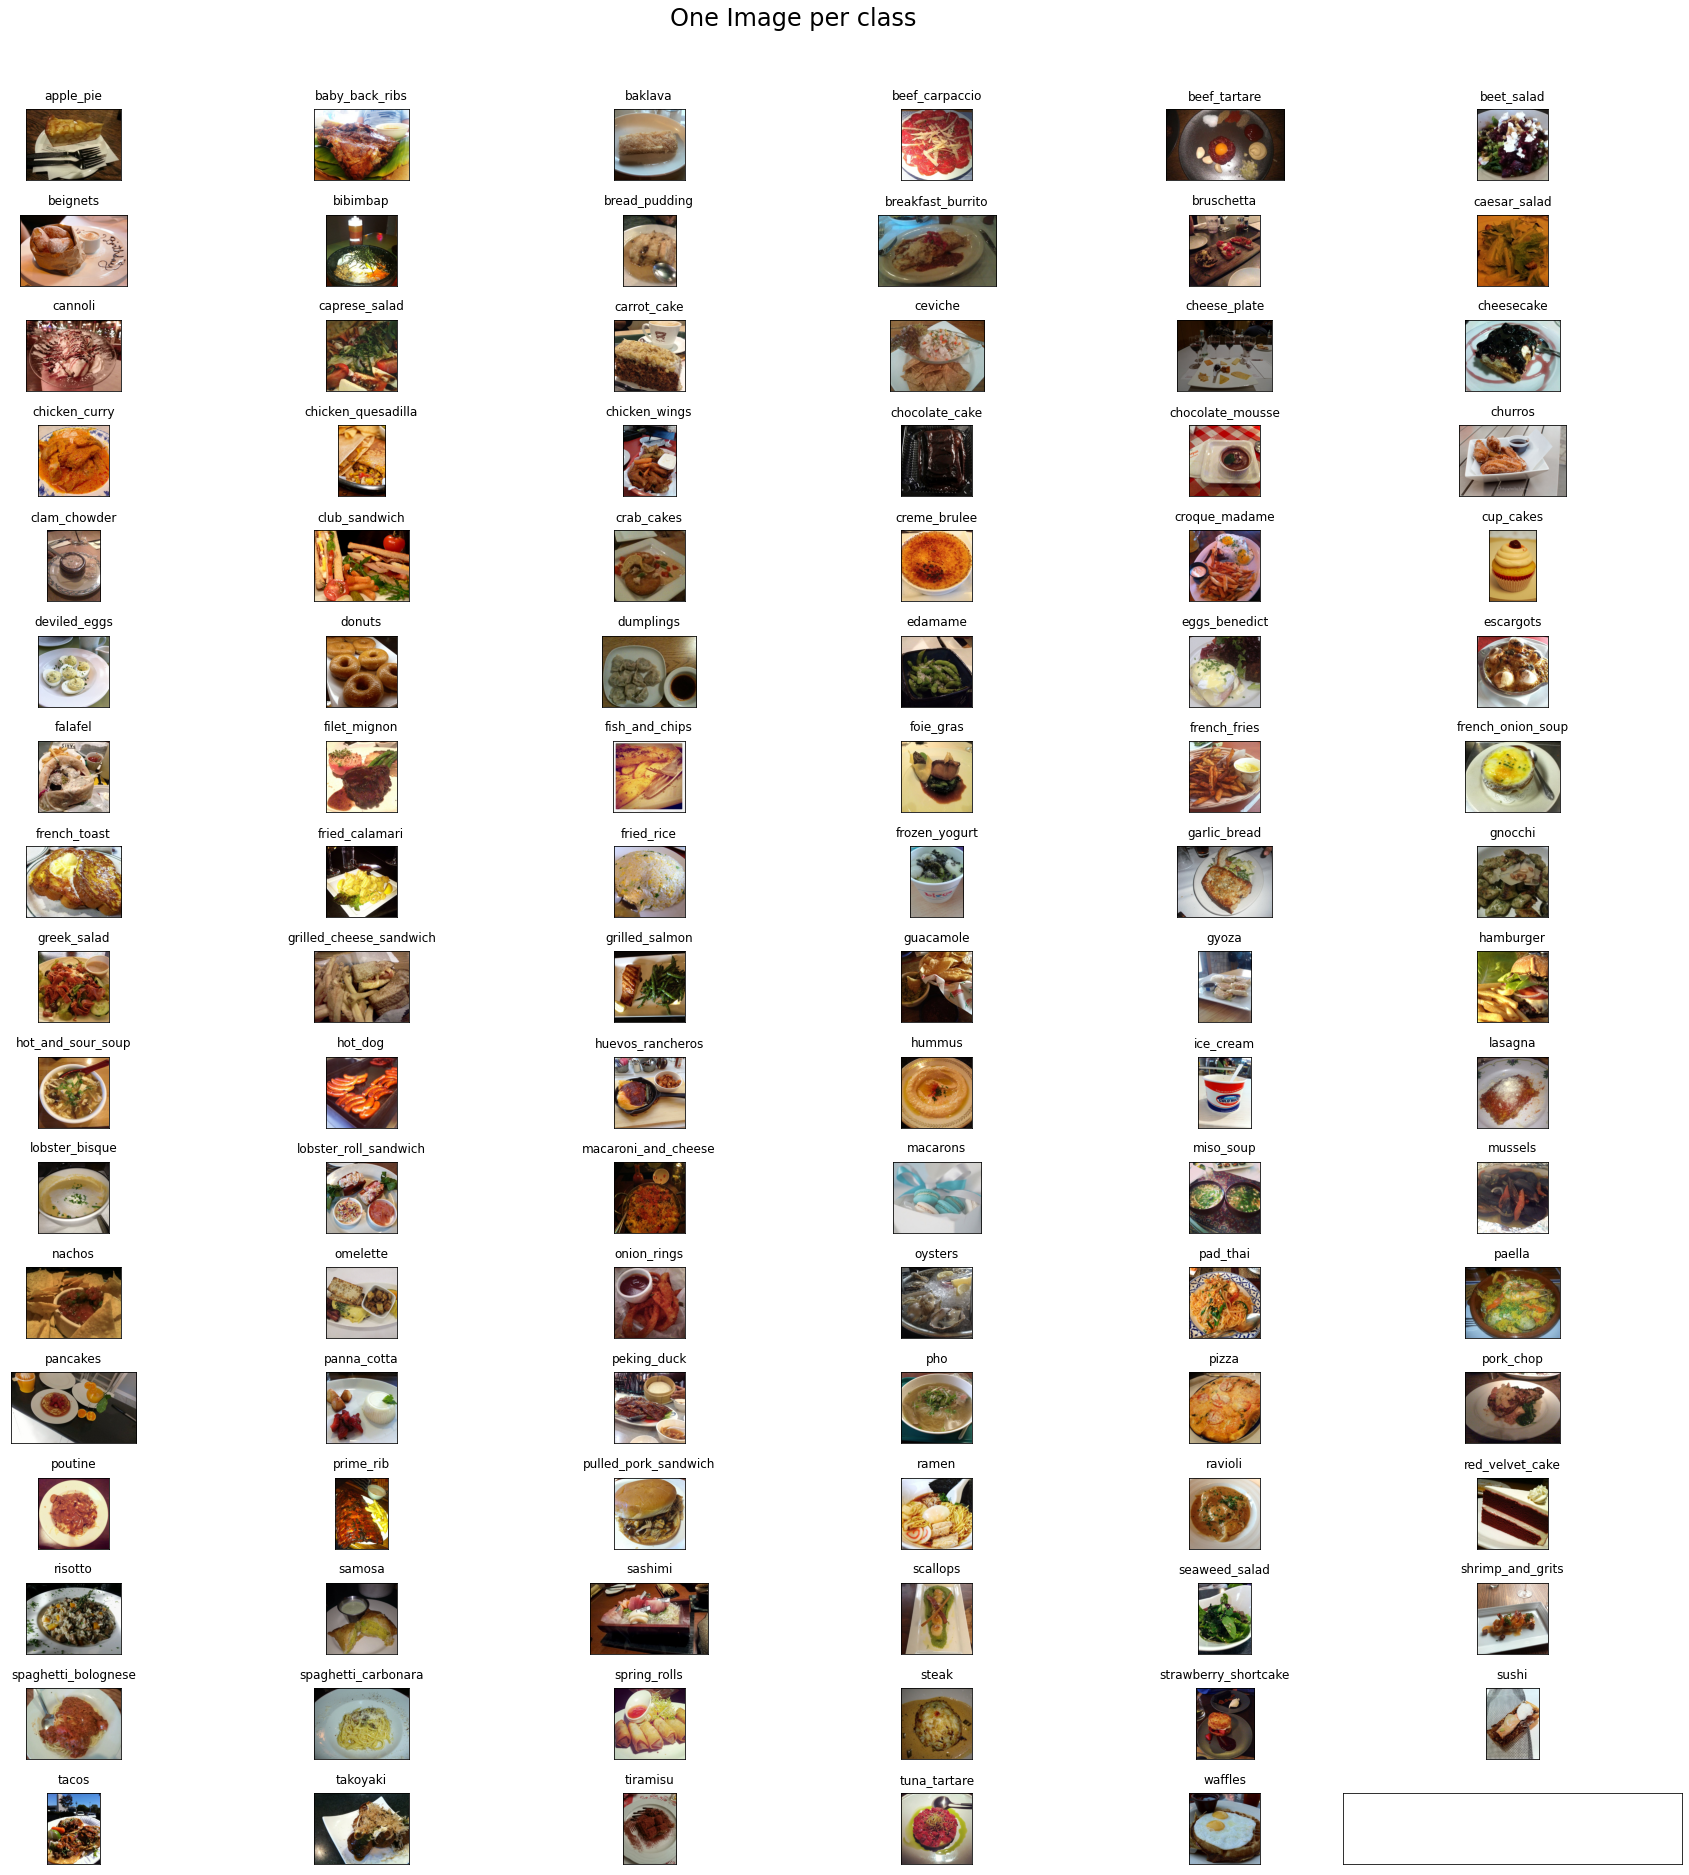

In [10]:
r = 17                                                                                #Let us take spaghetti_bolognese for example
c = 6
fig, ax = plt.subplots(r, c, figsize = (25, 25))
fig.suptitle("One Image per class", y = 1.04, fontsize = 24)

data_dir = "food-101/images"
food_sort = sorted(os.listdir(data_dir))
id = 0
for i in range(r):
  for j in range(c):
    try:
      food_selected = food_sort[id]
      # print(food_selected)
      id+=1
    except:
      break
    if food_selected == '.DS_Store':
      continue
    selected_img = os.listdir(os.path.join(data_dir, food_selected))                    #food-101/images/spaghetti_bolognese
    selected_img_random = np.random.choice(selected_img)                                #random choice from set of spaghetti_bolognese images

    image = plt.imread(os.path.join(data_dir, food_selected, selected_img_random))     #food-101/images/spaghetti_bolognese/2277460.jpg
    ax[i][j].imshow(image)
    ax[i][j].set_title(food_selected, pad = 10)

plt.setp(ax, xticks=[], yticks =[])
plt.tight_layout()

Specifying data generators. These help in rescaling the image, flipping it horizontally etc.

In [89]:
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0, 
                                                           width_shift_range = 0.2,
                                                           height_shift_range = 0.2,
                                                           shear_range = 0.2,
                                                           zoom_range = 0.2,
                                                           horizontal_flip = True,
                                                           fill_mode = 'nearest',
                                                           rotation_range = 40,
                                                           validation_split = 0.1)                                  

Specifying Train and Validation data generators

In [90]:
img_width=150
img_height = 150
data_dir = "food-101/images"
train_datagen = data_gen.flow_from_directory(data_dir,
                                              target_size = (img_width, img_height),
                                              color_mode = 'grayscale', 
                                              class_mode = 'categorical', 
                                              batch_size = 32, 
                                              interpolation = 'nearest',
                                              subset = 'training')

Found 90900 images belonging to 101 classes.


In [91]:
validation_datagen = data_gen.flow_from_directory(data_dir,
                                              target_size = (img_width, img_height),
                                              color_mode = 'grayscale', 
                                              class_mode = 'categorical', 
                                              batch_size = 32, 
                                              interpolation = 'nearest',
                                              subset = 'validation')

Found 10100 images belonging to 101 classes.


Basic CNN

In [92]:
model1 = Sequential()
model1.add(Conv2D(16, (3,3), activation='relu', padding = 'same', input_shape = (img_width, img_height, 1)))
model1.add(MaxPooling2D(2,2))
model1.add(Conv2D(32, (3,3), padding = 'same',  activation='relu'))
model1.add(MaxPooling2D(2,2))
model1.add(Conv2D(64, (3,3), padding = 'same', activation='relu'))
model1.add(MaxPooling2D(2,2))
model1.add(Conv2D(128, (3,3),padding = 'same',  activation='relu'))
model1.add(MaxPooling2D(2,2))

model1.add(Flatten())
model1.add(Dense(512, activation ='relu'))
# model1.add(Activation('relu'))
model1.add(Dense(101, activation='softmax'))

Defining Call back

In [93]:
callback = tf.keras.callbacks.EarlyStopping(monitor = 'accuracy', baseline = 0.9, patience = 5 ) 

In [94]:
model1.compile(optimizer='adam',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])
model1.fit(train_datagen, validation_data = validation_datagen, epochs = 5,steps_per_epoch = 100, callbacks = [callback])
# print(model1.accuracy, model1.loss,model1.val_acc, model1.val_loss)

Epoch 1/5
100/100 [==============================] - 80s 802ms/step - loss: 4.6161 - accuracy: 0.0100 - val_loss: 4.6163 - val_accuracy: 0.0099
Epoch 2/5
100/100 [==============================] - 79s 792ms/step - loss: 4.6159 - accuracy: 0.0106 - val_loss: 4.6154 - val_accuracy: 0.0099
Epoch 3/5
100/100 [==============================] - 77s 773ms/step - loss: 4.6153 - accuracy: 0.0084 - val_loss: 4.6155 - val_accuracy: 0.0099
Epoch 4/5
100/100 [==============================] - 77s 777ms/step - loss: 4.6155 - accuracy: 0.0122 - val_loss: 4.6155 - val_accuracy: 0.0099
Epoch 5/5
100/100 [==============================] - 78s 790ms/step - loss: 4.6155 - accuracy: 0.0097 - val_loss: 4.6155 - val_accuracy: 0.0099


Using a basic cnn, we get 
accuracy = 1 %
training and validation loss of 46% 

Transfer Learning using EFFICIENT NET

We will be taking Efficient Net from tensorflor

In [54]:
import tensorflow_hub as hub
Efficientnet = 'https://tfhub.dev/google/efficientnet/b0/classification/1'

In [55]:
model_tl = tf.keras.Sequential([
    hub.KerasLayer(Efficientnet, trainable = False, input_shape = (224,224,3), name = 'Efficientnet_b0'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(101, activation = 'softmax', name = 'Output_layer')
])

model_tl.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy']
)

In [56]:
tl_model = model_tl.fit(train_datagen, validation_data = validation_datagen, steps_per_epoch = 100, epochs = 5, verbose = 1, callbacks = [callback])

Epoch 1/5
100/100 [==============================] - 249s 996ms/step - loss: 4.6798 - accuracy: 0.0241 - val_loss: 4.5235 - val_accuracy: 0.0322
Epoch 2/5
100/100 [==============================] - 99s 1s/step - loss: 4.4577 - accuracy: 0.0409 - val_loss: 4.4644 - val_accuracy: 0.0452
Epoch 3/5
100/100 [==============================] - 100s 1s/step - loss: 4.4045 - accuracy: 0.0522 - val_loss: 4.4015 - val_accuracy: 0.0520
Epoch 4/5
100/100 [==============================] - 98s 993ms/step - loss: 4.3779 - accuracy: 0.0569 - val_loss: 4.3649 - val_accuracy: 0.0552
Epoch 5/5
100/100 [==============================] - 99s 998ms/step - loss: 4.3331 - accuracy: 0.0603 - val_loss: 4.3557 - val_accuracy: 0.0562


Using transfer learning we get 
accuracy = 6 %
training and validation loss = 43%

All convolutional Net

In [95]:
from tqdm import tqdm
import cv2 
import os     
from random import shuffle

image_size = 32,32

In all Conv Net we set the number of nodes according to how many number of classes or outputs we need. In the end we use 101 as the number of outputs..There is no implementation of Dense Layer in the network. 
I have tried to implement All Convolutional Network in Keras. I was not able to find a good reference for this model so please let me know if it is wrong.

In [96]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations

model2 = Sequential()
model2.add(Conv2D(96, (3,3), activation='relu', input_shape = (150, 150, 1)))
model2.add(Conv2D(96, (3,3), activation='relu'))
model2.add(MaxPooling2D(3,3))

model2.add(Conv2D(192, (3,3), activation='relu'))
model2.add(Conv2D(192, (3,3), activation='relu'))
model2.add(MaxPooling2D(3,3))

model2.add(Conv2D(384, (1,1), activation='relu'))
model2.add(Conv2D(101, (1,1), activation='relu'))


model2.add(GlobalAveragePooling2D())
model2.add(Flatten())
model2.add(layers.Activation(activations.softmax))

In [97]:
model2.compile(loss='categorical_crossentropy', optimizer='adam',
             metrics=['accuracy'])

In [98]:
model2 = model2.fit(train_datagen, validation_data = validation_datagen, steps_per_epoch = 100, epochs = 5, verbose = 1, callbacks = [callback])

Epoch 1/5
100/100 [==============================] - 92s 897ms/step - loss: 4.6154 - accuracy: 0.0106 - val_loss: 4.6153 - val_accuracy: 0.0099
Epoch 2/5
100/100 [==============================] - 90s 904ms/step - loss: 4.6155 - accuracy: 0.0063 - val_loss: 4.6151 - val_accuracy: 0.0083
Epoch 3/5
100/100 [==============================] - 88s 886ms/step - loss: 4.6154 - accuracy: 0.0069 - val_loss: 4.6151 - val_accuracy: 0.0099
Epoch 4/5
100/100 [==============================] - 88s 889ms/step - loss: 4.6152 - accuracy: 0.0100 - val_loss: 4.6151 - val_accuracy: 0.0099
Epoch 5/5
100/100 [==============================] - 87s 877ms/step - loss: 4.6151 - accuracy: 0.0091 - val_loss: 4.6151 - val_accuracy: 0.0099


Using All Convolutional Net we got an accuracy of approximately 1 and training and validation loss of around 46%

I have used less number of layers and neurons for a dataset of 101000 images. That is the reason the accuracy is very low in all of the models.